# Exponential Weighted Experts Prediction

In [2]:
# Load libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib

In [3]:
# visualization functions
def plot_weights(w):
    wT = w.dropna().transpose()
    wT.sort_values(wT.columns[-1]).tail(10).transpose().plot.line()

## Set up

All the simulation code can be found in Exponential_Sim.py. Currently we are using single factor OLS regressions (intercept included) as predictors. The program is set up to be able to generalize to any predictive model using object oriented programming by wrapping models in the `Expert` abstract class.

The data generation code can be found in DGP.py. 


However, there appears to be an error generating non-linear returns at the moment -- they seem to be the same as linear returns... 



## Theory

The multiplicative weights algorithm gurantees that after $T$ rounds, for any expert $i$, we have 

$$\sum^T_{t=1} m^{(t)} \cdot p^{(t)} \le \sum^T_{t=1} m_i^{(t)} + \eta \sum^T_{t=1} |m_i^{(t)}| + \frac{\ln(n)}{\eta}$$

where $m^{(t)}$ is the vector of costs that were encurred by each of the $n$ experts, where costs are between $[-1,1]$, and $\eta \le 0.5$ is the learning rate. Thus, our expected error across the whole sample, $\sum^T_{t=1} m^{(t)} \cdot p^{(t)}$, is bounded by the best expert. In this case our expected error is simply $\frac{RSS}{TSS}$ if we use a squared loss function. Suppose that the $\frac{RSS}{TSS}$ of the best expert is $0.95$, and we update the weights $60$ times. Then we minimize the upper bound by choosing $\eta \approx 0.3$. The exponential weights algorithm has a slightly different bound. All of this can be found in the paper Arora 2012.

Unfortunately, the squared loss function does not have range $[-1,1]$ so we need to scale it somehow. Currently we are using an one sided squared arctan function as shown below.

$$\frac{4}{\pi} \arctan((\kappa(\hat{y}-y))^2)-1$$

This function has the nice properties of
- producing a cost of -1 when the error is 0
- is bounded by 1 when the error is high
- has the largest derivative around the root

The default is to scale the function parameter $c$ such that the function equals 0 when the absolute prediction error is $0.05$, which is the mean absolute difference of the returns from the mean return. We can tune the hyperparameter $\kappa$ in our validation set.

For each of the $N$ assets, we predict and compute the cost using the cost function, and then sum up the costs instead of summing up the absolute errors first and then passing that through the cost function. We do this to preserve linearity of the costs when updating.


## Model Variations

There are a few parameters to the model that we can change, noted below:
- we can choose between using an exponential update method (hedge algorithm) or multiplicative update method
    - the exponential method has nicer linear properties with regards to updates (costs are invariant under summation)
- we can choose between weighted probability of choosing a model or weighted average, both of which would have the same expected value
    - weighted average should minimize volatility and thus increase performance
- we can either update the underlying models in an online fashion or use underlying models trained during the burn-in period
    - the model should do better if we update the models online too

## Problems Encountered
- The main problem was that it takes a long time to run simulations. I managed to reduce the time down to 200 seconds per simulation through some micro-optimizations after profiling the code. However, each simulation still takes around 200 seconds currently, which means that running all 200 samples would take around 11 hours. Some things that helped optimize the code included:
    - reducing initializations of data structures
    - using numpy arrays instead of base python
    - reducing type conversions and array access
    - reducing redundant data structures
- The complexity of the components of the algorithm introduces many possibilities for bugs. Run the unit tests `test_exp_sim.py` first


## MC Simulation

The procedure is as follows:


1. Separate the data into three subsamples -- training, validation, and testing
1. Train the model on the training set -- thus finding the weights $w_t$. Since the predictions from the underlying models will be horrible without data, we will not update the underlying experts in an online fashion during the training period and instead feed the experts all the data at the start instead.
1. Conduct online predictions on validation sample while updating weights and the underlying models based on new and old data. The underlying experts will be updated in an online fashion using the new data during validation. The frequency in which we update the weights and experts is $\tau$, the update period
1. Tune the hyperparameters -- the update period $\tau$, the learning rate $\eta$, and the cost scale $\kappa$ -- based on the validation sample
1. Report $R^2$ of model on validation set as IS $R^2$
1. Use $w_t$ and underlying models from training to create offline predictions on testing subsample -- ie. do not update underlying model and weights based on new data
1. Report $R^2$ of model on testing set as OOS $R^2$
1. Report changes in $R^2$ over time of both IS and OOS. This is done by computing the $R^2$ for each period based on the update period, where we use the mean of the returns in the training data in the denominator
1. Report changes in weights over time to see the importance of the underlying models over time

We run this procedure on each of the 100 MC samples generated and aggregate the following data by taking the mean:
- IS validation $R^2$
- OOS $R^2$
- Weights for all three subsamples
- Mean optimal hyperparameters

## Summary Statistics

Note that we use the mean of the training data in the denominator for any $R^2$ calculations. Also note that we are presenting normalized weights.

In [60]:
# Load and aggregate data from all 100 MC simulations
M = 1
M_end = 100
Mo = 1
MCs = list(range(M+1, M_end+1))
path = "Simu/Simu_100/Reg1/"
modeln = 50


isr = pd.read_csv(path + "ISR/b%d_%d_%d.csv" % (Mo, M, modeln), header=None)
oosr = pd.read_csv(path + "OOSR/b%d_%d_%d.csv" % (Mo, M, modeln), header=None)
weights = pd.read_csv(path + "VIP/b%d_%d_%d.csv" % (Mo, M, modeln), header=None)
hyp = pd.read_csv(path + "HYP/b%d_%d_%d.csv" % (Mo, M, modeln), header=None)
ris = pd.read_csv(path + "ris_%d_%d.csv" % (Mo, M), header=None)
roos = pd.read_csv(path + "roos_%d_%d.csv" % (Mo, M), header=None)

# agg across all MCs
for M in MCs:
    isr += pd.read_csv(path + "ISR/b%d_%d_%d.csv" % (Mo, M, modeln), header=None)
    oosr += pd.read_csv(path + "OOSR/b%d_%d_%d.csv" % (Mo, M, modeln), header=None)
    weights += pd.read_csv(path + "VIP/b%d_%d_%d.csv" % (Mo, M, modeln), header=None)
    hyp += pd.read_csv(path + "HYP/b%d_%d_%d.csv" % (Mo, M, modeln), header=None)
    ris += pd.read_csv(path + "ris_%d_%d.csv" % (Mo, M), header=None)
    roos += pd.read_csv(path + "roos_%d_%d.csv" % (Mo, M), header=None)

# take mean
isr /= M_end
oosr /= M_end
weights /= M_end
hyp /= M_end
ris /= M_end
roos /= M_end

weights3 = weights.div(weights.sum(axis=1), axis=0)

In [21]:
summary3 = pd.concat([ris, roos, hyp])
summary3['index'] = ['ris','roos','avg tau','avg eta', 'avg kappa']
summary3.set_index('index', inplace=True)
summary3

,0
index,
ris,0.002024
roos,0.002367
avg tau,30.100000
avg eta,0.491000
avg kappa,887.000000


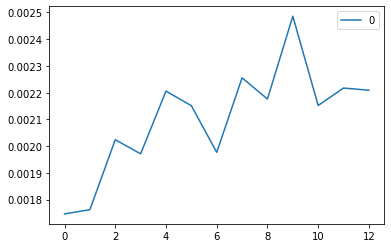

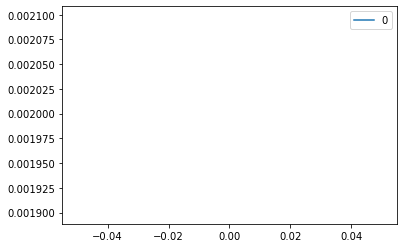

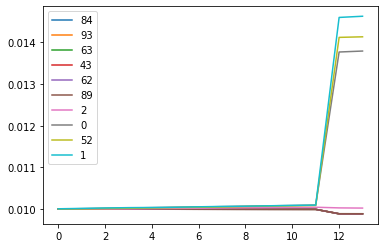

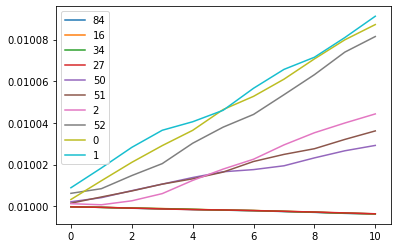

In [65]:
isr.plot.line()
oosr.plot.line()

# lets look at the weights of the top 10 predictors
plot_weights(weights3)
plot_weights(weights3[:11])

## MC for Model 2 (non-linear)

In [79]:
# Load and aggregate data from all 100 MC simulations
M = 1
M_end = 100
Mo = 2
MCs = list(range(M+1, M_end+1))
path = "Simu/Simu_100/Reg1/"
modeln = 50


isr = pd.read_csv(path + "ISR/b%d_%d_%d.csv" % (Mo, M, modeln), header=None)
oosr = pd.read_csv(path + "OOSR/b%d_%d_%d.csv" % (Mo, M, modeln), header=None)
weights = pd.read_csv(path + "VIP/b%d_%d_%d.csv" % (Mo, M, modeln), header=None)
hyp = pd.read_csv(path + "HYP/b%d_%d_%d.csv" % (Mo, M, modeln), header=None)
ris = pd.read_csv(path + "ris_%d_%d.csv" % (Mo, M), header=None)
roos = pd.read_csv(path + "roos_%d_%d.csv" % (Mo, M), header=None)

# agg across all MCs
for M in MCs:
    isr += pd.read_csv(path + "ISR/b%d_%d_%d.csv" % (Mo, M, modeln), header=None)
    oosr += pd.read_csv(path + "OOSR/b%d_%d_%d.csv" % (Mo, M, modeln), header=None)
    weights += pd.read_csv(path + "VIP/b%d_%d_%d.csv" % (Mo, M, modeln), header=None)
    hyp += pd.read_csv(path + "HYP/b%d_%d_%d.csv" % (Mo, M, modeln), header=None)
    ris += pd.read_csv(path + "ris_%d_%d.csv" % (Mo, M), header=None)
    roos += pd.read_csv(path + "roos_%d_%d.csv" % (Mo, M), header=None)

# take mean
isr /= M_end
oosr /= M_end
weights /= M_end
hyp /= M_end
ris /= M_end
roos /= M_end

weights4 = weights.div(weights.sum(axis=1), axis=0)

In [53]:
summary4 = pd.concat([ris, roos, hyp])
summary4['index'] = ['ris','roos','avg tau','avg eta', 'avg kappa']
summary4.set_index('index', inplace=True)
summary4

,0
index,
ris,0.000367
roos,0.000481
avg tau,27.150000
avg eta,0.450000
avg kappa,850.000000


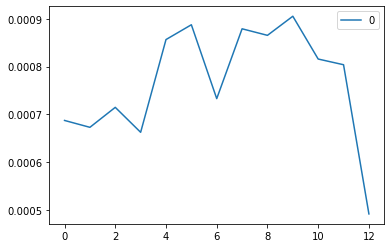

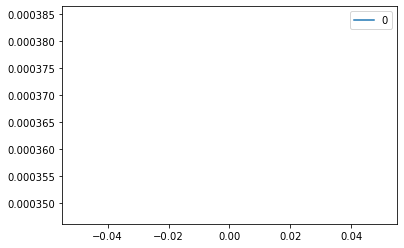

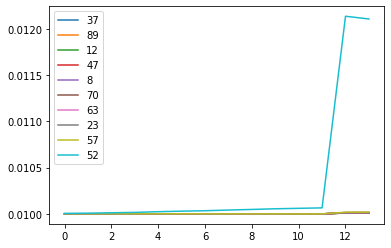

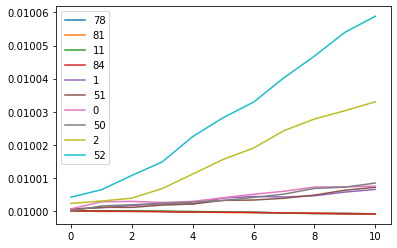

In [26]:
isr.plot.line()
oosr.plot.line()

# lets look at the weights of the top 10 predictors
plot_weights(weights4)
plot_weights(weights4[:11])

## Benchmarking

We present benchmarking data from the other different models below:

<!-- Table of model numbers
| Model Number | Description |
| --- | ---|
|1 | Simple OLS |
|2|Simple OLS+H|
|3|PCA Regression|
|4||
|5||
|6||
|7||
|8||
|9||
|10|| -->

In [37]:
# Dictionary of model indices
model_indices = {0:"Simple OlS", 1:"Simple OLS+H", 2:"PCA Regression", 3:"PLS Regression", 4:"Lasso", 5:"Lasso+H", 6:"Ridge", 7:"Ridge+H", 8:"Enet", 9:"Enet+H", 10:"Oracle", 11:"Group Lasso", 12:"Group Lasso+H",40:"Weighted Experts"}

### Linear Model

In [56]:
# Load and aggregate data from all 100 MC simulations
M = 1
M_end = 100
Mo = 1
MCs = list(range(M+1, M_end+1))
path = "Simu/Simu_BM100/Reg1/"
modelns = [5]

ris = pd.read_csv(path + "ris_%d_%d.csv" % (Mo, M), header=None)
roos = pd.read_csv(path + "roos_%d_%d.csv" % (Mo, M), header=None)
vips = []

for i in range(len(modelns)):
    vips.append(pd.read_csv(path + "VIP/b%d_%d_%d.csv" % (Mo, M, modelns[i]), header=None))

# agg across all MCs
for M in MCs:
    ris += pd.read_csv(path + "ris_%d_%d.csv" % (Mo, M), header=None)
    roos += pd.read_csv(path + "roos_%d_%d.csv" % (Mo, M), header=None)
    
    for i in range(len(modelns)):
        vips[i] += pd.read_csv(path + "VIP/b%d_%d_%d.csv" % (Mo, M, modelns[i]), header=None)


# take mean
ris /= M_end
roos /= M_end
for i in range(len(modelns)):
    vips[i]/= M_end

We find that the weighted experts model finds the correct predictors as shown in the importance table according to Lasso+H as shown below:

In [58]:
vips[0].sort_values(0).tail(10)

,0
68,0.000012
8,0.000013
63,0.000015
25,0.000024
2,0.001791
50,0.002074
51,0.002683
52,0.017228
1,0.018841
0,0.019508


In [78]:
pd.DataFrame(weights3.loc[11].sort_values().tail(10))

,11
84,0.009996
16,0.009996
29,0.009996
34,0.009996
50,0.010034
51,0.010039
2,0.010047
52,0.010089
0,0.010097
1,0.010098


In [59]:
summary = pd.DataFrame()
summary['ris'] = ris[0]
summary['roos'] = roos[0]

summary = summary.append({"ris":summary3.loc["ris"].values[0], "roos":summary3.loc["roos"].values[0]}, ignore_index=True)
summary['names'] = model_indices.values()

summary.set_index('names', inplace=True)
summary.sort_values("roos")

,ris,roos
names,,
Simple OlS,0.077320,-0.000596
Simple OLS+H,0.077174,0.000532
Weighted Experts,0.002024,0.002367
PCA Regression,0.029491,0.006698
PLS Regression,0.064646,0.027531
Group Lasso,0.063185,0.035620
Ridge,0.068504,0.035818
Group Lasso+H,0.062758,0.035952
Ridge+H,0.068162,0.036087


### Non-linear Model

In [54]:
# Load and aggregate data from all 100 MC simulations
M = 1
M_end = 100
Mo = 2
MCs = list(range(M+1, M_end+1))
path = "Simu/Simu_BM100/Reg1/"
modelns = [5]

ris = pd.read_csv(path + "ris_%d_%d.csv" % (Mo, M), header=None)
roos = pd.read_csv(path + "roos_%d_%d.csv" % (Mo, M), header=None)
vips = []

for i in range(len(modelns)):
    vips.append(pd.read_csv(path + "VIP/b%d_%d_%d.csv" % (Mo, M, modelns[i]), header=None))

# agg across all MCs
for M in MCs:
    ris += pd.read_csv(path + "ris_%d_%d.csv" % (Mo, M), header=None)
    roos += pd.read_csv(path + "roos_%d_%d.csv" % (Mo, M), header=None)
    
    for i in range(len(modelns)):
        vips[i] += pd.read_csv(path + "VIP/b%d_%d_%d.csv" % (Mo, M, modelns[i]), header=None)


# take mean
ris /= M_end
roos /= M_end
for i in range(len(modelns)):
    vips[i]/= M_end

The most important variables are shown below. The top six generally match the ones found the by weighted experts algorithm

In [15]:
vips[0].sort_values(0).tail(10)

,0
38,0.000012
25,0.000014
62,0.000014
39,0.000017
0,0.000531
1,0.000571
51,0.000746
50,0.000830
2,0.001179
52,0.008137


In [80]:
pd.DataFrame(weights4.loc[11].sort_values().tail(10))

,11
37,0.009999
84,0.009999
81,0.009999
11,0.009999
1,0.010006
0,0.010008
51,0.010009
50,0.010009
2,0.010034
52,0.010064


In [55]:
summary = pd.DataFrame()
summary['ris'] = ris[0]
summary['roos'] = roos[0]

summary = summary.append({"ris":summary4.loc["ris"].values[0], "roos":summary4.loc["roos"].values[0]}, ignore_index=True)
summary['names'] = model_indices.values()

summary.set_index('names', inplace=True)
summary.sort_values("roos")

,ris,roos
names,,
Simple OlS,0.032638,-0.059176
Simple OLS+H,0.032483,-0.057873
PLS Regression,0.009818,-0.004619
Enet,0.025081,-0.001987
Enet+H,0.024793,-0.001663
PCA Regression,0.005633,-0.000887
Group Lasso,0.032312,-0.000019
Group Lasso+H,0.031781,0.000093
Ridge,0.015730,0.000444


0    0.002024
Name: ris, dtype: float64

## Notes
- I am very curious about how an essemble model using exponential weighted majority experts would perform, where each expert is a model (such as an OLS model, a Lasso model, etc.), especially when benchmarked in an online fashion
- The simulation takes a significant amount of time (> 10 minutes) to run on my computer with just 400 periods
- Expanding linear regression tends to perform poorly with many factors probably due to collinearity between factors
- What is the optimal learning rate? We can find this theoretically by minimizing the upper bounds of our losses with respect to $\eta$
- There may be a way to "lasso" and get rid of irrelevant experts in the prediction. Perhaps there could be a 10 best expert cutoff point. We could also apply some function to the weights that emphasizes the better experts. The bad experts tend to create too much noise in the model
- 5 single factor OLS experts + 1 all factors OLS expert seems to perform better than just all factor OLS for the samples I have run
- What is the best cost function to use? Currently we are using arctan
- The current simulations suggest that the optimal update frequency is the maximum update frequency -- why is it?

## References

Arora, Sanjeev, Elad Hazan, and Satyen Kale. "The multiplicative weights update method: a meta-algorithm and applications." Theory of Computing 8.1 (2012): 121-164.


## End of document, scratchwork below

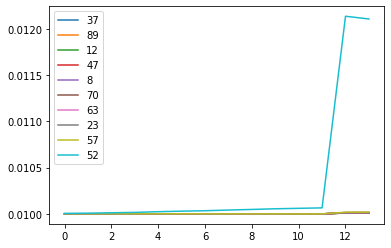

In [24]:


# weightsT = weights.dropna().transpose()
# weightsT.sort_values(weightsT.columns[-1]).tail(10).transpose().plot.line()
plot_weights(weights)

## Benchmark

We can benchmark our $R^2$ against those described in the paper Empircal Asset Pricing by different models such as OLS

In [3]:
sum_returns = np.zeros(36000)

for M in range(1,101):
    r1 = pd.read_csv('Simu/SimuData_100/' + 'r%d_%d_%d.csv' % (1, M, 1),
                     delimiter=',').iloc[:, 0].values
    sum_returns += r1**2
sum_returns = sum_returns/100

## Summary Statistics

The in sample r squared is shown below. Note that we use the (average) sum of squared returns as the denominator because in practice estimates of the mean of returns tends to be horrible. Also note that we are presenting normalized weights.

IS R Squared 0.0017582031367139317
OOS R Squared 0.0016794191175438788


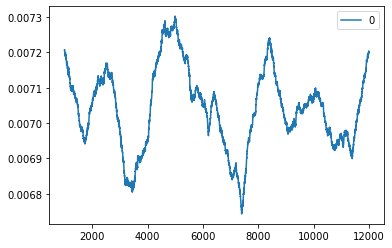

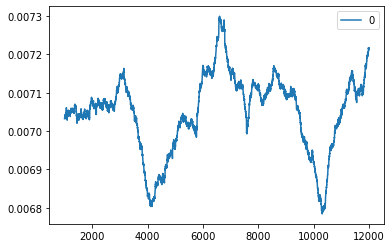

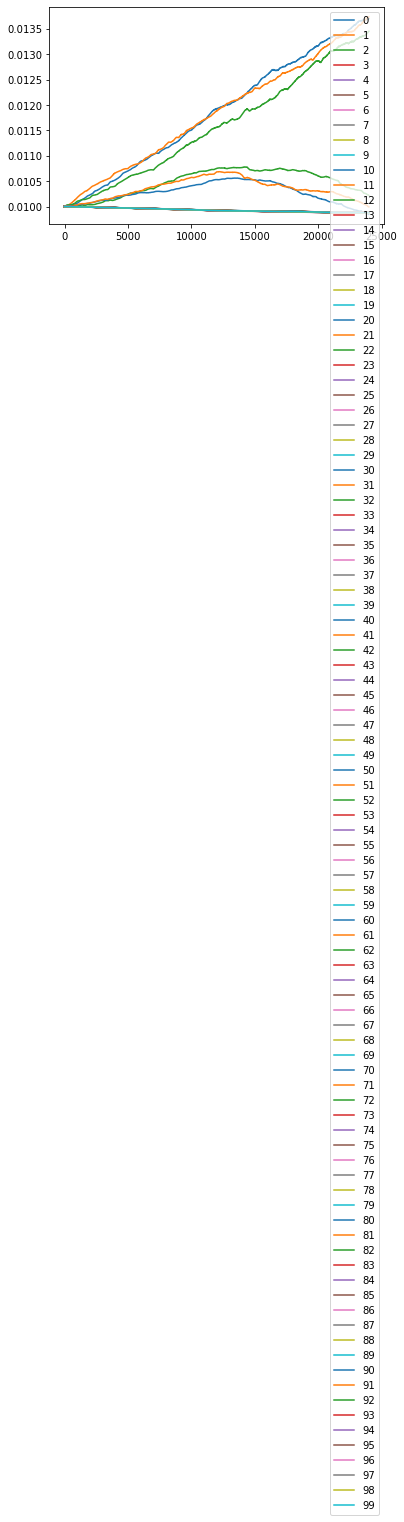

In [81]:
# Load data from MC simulations
isr = pd.read_csv("Simu/Simu_100/Reg1/ISR/b1_100_31.csv", header=None)
oosr = pd.read_csv("Simu/Simu_100/Reg1/OOSR/b1_100_31.csv", header=None)
weights = pd.read_csv("Simu/Simu_100/Reg1/VIP/b1_100_31.csv", header=None)
y = pd.read_csv("Simu/SimuData_100/r1_1_1.csv")
weights = weights.div(weights.sum(axis=1), axis=0)

# -y.iloc[burn_in:training_stop].mean()

R_squared = 1-np.sum(isr.values)/np.sum(sum_returns[12000:24000])
print('IS R Squared', R_squared)

R_squared = 1-np.sum(oosr.values)/np.sum(sum_returns[24000:36000])
print('OOS R Squared', R_squared)

isr.rolling(1000).mean().plot.line()
oosr.rolling(1000).mean().plot.line()
weights.plot.line()


# R_squared =  1-np.sum(losses_OOS)/np.sum((y.iloc[training_stop:testing_stop]-y.iloc[training_stop:testing_stop].mean())**2)
# print(R_squared)

# R_squared = 1-np.sum(losses_IS_B)/np.sum((y.iloc[burn_in:training_stop]-y.iloc[burn_in:training_stop].mean())**2)
# print(R_squared)

# R_squared = 1-np.sum(losses_OOS_B)/np.sum((y.iloc[burn_in:training_stop]-y.iloc[burn_in:training_stop].mean())**2)
# print(R_squared)

In [2]:
# Load data from MC simulations
isr = pd.read_csv("Simu/Simu_100/Reg1/ISR/b1_100_33.csv", header=None)
oosr = pd.read_csv("Simu/Simu_100/Reg1/OOSR/b1_100_33.csv", header=None)
weights = pd.read_csv("Simu/Simu_100/Reg1/VIP/b1_100_33.csv", header=None)
y = pd.read_csv("Simu/SimuData_100/r1_1_1.csv")
weights = weights.div(weights.sum(axis=1), axis=0)

# -y.iloc[burn_in:training_stop].mean()

R_squared = 1-np.sum(isr.values)/np.sum(sum_returns[12000:24000])
print('IS R Squared', R_squared)

R_squared = 1-np.sum(oosr.values)/np.sum(sum_returns[24000:36000])
print('OOS R Squared', R_squared)

isr.rolling(1000).mean().plot.line()
oosr.rolling(1000).mean().plot.line()
weights.plot.line()


NameError: name 'sum_returns' is not defined

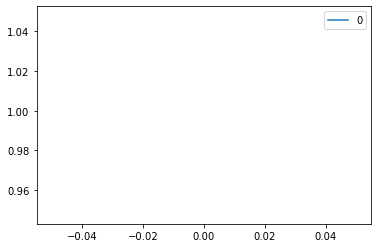

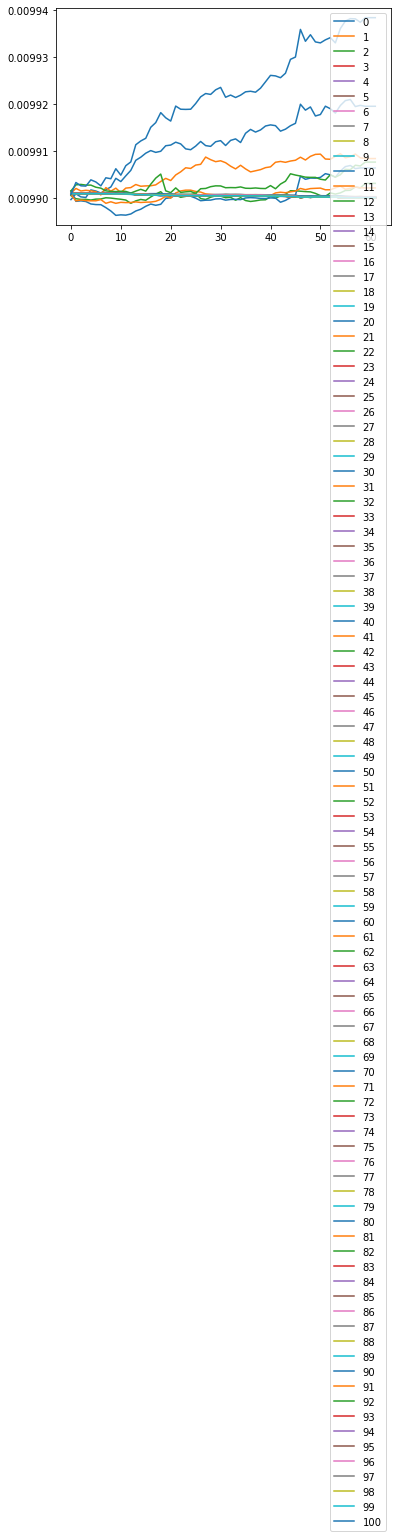

In [24]:
modeln = 40

# Load data from MC simulations
isr = pd.read_csv("Simu/Simu_100/Reg1/ISR/b1_1_%d.csv" % (modeln), header=None)
oosr = pd.read_csv("Simu/Simu_100/Reg1/OOSR/b1_1_%d.csv" % (modeln), header=None)
weights = pd.read_csv("Simu/Simu_100/Reg1/VIP/b1_1_%d.csv" % (modeln), header=None)
y = pd.read_csv("Simu/SimuData_100/r1_1_1.csv")
weights = weights.div(weights.sum(axis=1), axis=0)

# -y.iloc[burn_in:training_stop].mean()

# R_squared = 1-np.sum(isr.values)/np.sum(sum_returns[12000:24000])
# print('IS R Squared', R_squared)

# R_squared = 1-np.sum(oosr.values)/np.sum(sum_returns[24000:36000])
# print('OOS R Squared', R_squared)

# isr.rolling(1000).mean().plot.line()
oosr.plot.line()
# oosr.rolling(1000).mean().plot.line()
weights.plot.line()


In [23]:
weights
# weights.sum(axis=1)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,...,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901
1,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,...,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901
2,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,...,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901
3,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,...,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901
4,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,...,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,...,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901
58,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,...,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901
59,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,...,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901
60,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,...,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901


In [53]:
len(losses_OOS)
len(y.iloc[training_stop:testing_stop])
X.corr()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,0.007368,-0.000637,0.019488,0.021121,-0.006630,-0.009388,0.028957,-0.000731,0.011059,...,0.013081,-0.014916,0.007184,-0.027716,-0.010603,-0.000912,-0.008726,-0.031770,-0.005668,-0.003460
1,0.007368,1.000000,0.021299,0.009921,0.007183,0.013289,-0.022710,0.023558,-0.022396,-0.028767,...,-0.010288,0.017507,0.012600,-0.002737,-0.015570,0.000064,0.007014,0.024311,-0.004863,0.008424
2,-0.000637,0.021299,1.000000,0.013086,-0.034064,-0.016888,0.043304,-0.000532,0.004087,0.010595,...,0.021983,-0.003500,0.017549,0.012884,-0.020395,0.002209,0.012172,-0.000379,0.014510,0.016728
3,0.019488,0.009921,0.013086,1.000000,0.007254,0.027920,-0.004540,0.007688,-0.014265,-0.004433,...,-0.009807,-0.016504,-0.001727,-0.010643,-0.011553,-0.011967,-0.036264,-0.015110,0.005292,0.014467
4,0.021121,0.007183,-0.034064,0.007254,1.000000,-0.016028,-0.058442,0.037972,0.039613,-0.019256,...,-0.020498,-0.002819,0.004107,-0.014859,0.009300,-0.006891,0.006159,-0.028795,0.003736,0.014696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.000912,0.000064,0.002209,-0.011967,-0.006891,-0.026586,-0.009703,-0.011379,0.023850,-0.020344,...,0.034039,0.010927,-0.055061,0.023049,0.051537,1.000000,0.014793,0.025929,-0.050829,0.002523
96,-0.008726,0.007014,0.012172,-0.036264,0.006159,-0.016670,-0.006239,-0.011939,-0.000927,0.019321,...,-0.014027,-0.008919,-0.014319,0.051167,-0.000212,0.014793,1.000000,-0.003120,-0.015137,-0.007784
97,-0.031770,0.024311,-0.000379,-0.015110,-0.028795,0.010527,-0.019909,0.032931,0.004340,-0.005837,...,-0.001715,-0.025164,0.040223,-0.041856,0.056908,0.025929,-0.003120,1.000000,0.005789,0.029194
98,-0.005668,-0.004863,0.014510,0.005292,0.003736,-0.011597,0.012216,0.000752,0.017677,0.031393,...,0.008445,0.048145,0.076795,-0.024854,0.014584,-0.050829,-0.015137,0.005789,1.000000,0.004405


## Non-linear model

In [8]:
# Load data
X = pd.read_csv("Simu/SimuData_100/c1.csv")
y = pd.read_csv("Simu/SimuData_100/r2_1_1.csv")

In [14]:
# Start with linear equal weightings 
weights = np.full(len(models),1)
eta = 0.1 # the learning rate
burn_in = 50

# store data on costs of chosen prediction
losses2 = []

# Online predictions timewise
for t in range(burn_in,500):
    
    # get predictions
    predictions = [m(X.iloc[:t,:],y.iloc[:t],X.iloc[t:t+1,:]) for m in models]
    
    # choose a prediction randomly according to weights
    chosen = np.random.choice(predictions, p = weights/np.sum(weights))
    
    # alternatively use weighted average
#     chosen = np.dot(predictions, weights/np.sum(weights))
    
    losses2.append(cost(y.iloc[t,0],chosen))
    
    # update weights using exponential update (hedge algorithm)
    weights = [weights[i]*np.exp(-eta * cost(y.iloc[t,0],predictions[i])) for i in range(len(weights))]
    
    # alternatively update weights using multiplicative weights
#     weights = [weights[i]*(1-eta * cost(y.iloc[t,0],predictions[i])) for i in range(len(weights))]

In [17]:
R_squared = 1-np.sum(losses2)/np.sum((y-y.mean())**2)
print(R_squared)

0    0.987126
dtype: float64


In [16]:
losses2

[0.004146702629715354,
 0.01674577501629206,
 0.0009753033770309526,
 0.0011943902478576292,
 8.417722718263713e-05,
 0.0011660362492935204,
 0.0022324467561851153,
 0.02285194192741877,
 0.001772717402072283,
 0.004349611829806382,
 1.6863876966656723e-09,
 0.0743942183319554,
 0.00035723009852048045,
 0.00527436395657891,
 0.014514891565922568,
 0.0029761651083005714,
 6.389836752132258e-05,
 0.0031881197425641526,
 0.001108509388455499,
 0.010667854777263208,
 0.05916915454830446,
 0.00985891916801289,
 9.263048713600135e-05,
 0.004123225223741411,
 0.003209777078913169,
 0.0049812042233881824,
 7.147686822876122e-05,
 0.007193911861117684,
 0.009505966072368989,
 0.0006328449687311501,
 0.0007785102487167106,
 0.004232957490568027,
 0.00071176789536819,
 0.010474729630592039,
 0.009357951481642765,
 3.97168558479594e-06,
 0.017301028183372997,
 0.0026280495941823382,
 0.020614612123813894,
 0.0010205325504537956,
 0.0022276224026019087,
 0.0011057472636020942,
 0.007018173098063463

In [8]:
pd.DataFrame(losses_IS).to_csv('losses_IS.csv', index = False)

In [4]:
X.shape

(36000, 100)

In [4]:
a = np.array([[2,3],[4,5]])

In [5]:
a/3

array([[0.66666667, 1.        ],
       [1.33333333, 1.66666667]])

In [6]:
a[1][1] += 9

In [7]:
a

array([[ 2,  3],
       [ 4, 14]])

In [8]:
a[1]

array([ 4, 14])

In [10]:
a[:,1]

array([ 3, 14])

In [15]:
b = np.array(1)

In [12]:
b

array(1)

In [14]:
b

array([1])

In [19]:
a[1][1].reshape(-1, 1)

array([[14]])

In [24]:
[(i,j) for i in range(4) for j in range(3)]

[(0, 0),
 (0, 1),
 (0, 2),
 (1, 0),
 (1, 1),
 (1, 2),
 (2, 0),
 (2, 1),
 (2, 2),
 (3, 0),
 (3, 1),
 (3, 2)]

In [2]:
c = np.zeros((20,5))

In [5]:
c[1] += [1,2,3,4,5]

In [10]:
c

array([[0., 0., 0., 0., 0.],
       [1., 2., 3., 4., 5.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [6]:
c[:,2]

array([0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [7]:
c

array([[0., 0., 0., 0., 0.],
       [1., 2., 3., 4., 5.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [10]:
a = np.array([[2,3],[4,5],[5,6]])

In [11]:
a + a

array([[ 4,  6],
       [ 8, 10],
       [10, 12]])

In [5]:
a

NameError: name 'a' is not defined

In [6]:
a = np.array([2,3,4])

In [16]:
def fff(ar):
    np.add(ar, 1, out = ar)
    return ar

In [17]:
fff(a)

array([3, 4, 5])

In [18]:
a

array([3, 4, 5])